# Arrhythmic Heartbeat Classification Model
## ECE 284 Project - Spring 2025
## Stephen Wilcox

In [ ]:
%pip install --user wfdb numpy scipy matplotlib scikit-learn torch torchvision torchaudio biosppy peakutils

In [1]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from biosppy.signals import ecg
from collections import Counter
import time

In [2]:
BEAT_DURATION = 1.0  #seconds
DATA_DIR = '../data'
MITDB_PATH = os.path.join(DATA_DIR, 'mitdb')
NSRDB_PATH = os.path.join(DATA_DIR, 'nsrdb')


def extract_beat(signal, r_loc, beat_len):
    half_len = beat_len // 2
    if r_loc - half_len < 0 or r_loc + half_len > len(signal):
        return None
    return signal[r_loc - half_len: r_loc + half_len]

def process_mitdb_record(record_name):
    record_path = os.path.join(MITDB_PATH, record_name)
    record = wfdb.rdrecord(record_path)
    ann = wfdb.rdann(record_path, 'atr')
    signal = record.p_signal[:, 0]
    fs = record.fs
    beat_len = int(BEAT_DURATION * fs)

    beats = []
    labels = []
    for i, r_loc in enumerate(ann.sample):
        beat = extract_beat(signal, r_loc, beat_len)
        if beat is not None:
            beats.append(beat)
            labels.append(ann.symbol[i])
    return beats, labels

def process_nsrdb_record(record_name, segment_duration=3600):
    record_path = os.path.join(NSRDB_PATH, record_name)
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    fs = record.fs

    segment_samples = int(segment_duration * fs)
    if segment_samples > len(signal):
        segment_samples = len(signal)

    segment_signal = signal[:segment_samples]

    # Run ECG peak detection on the 1-hour segment only
    ts, filtered, rpeaks, *_ = ecg.ecg(signal=segment_signal, sampling_rate=fs, show=False)

    beats = []
    labels = []

    for r in rpeaks:
        beat = extract_beat(filtered, r, beat_len=128)
        if beat is not None:
            beats.append(beat)
            labels.append('N')  # assume normal for NSRDB
    print(f"Processed NSRDB record {record_name}, beats found: {len(beats)}")
    return beats, labels



In [3]:
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, 'processed_beats_f.npz')

def upsample_list(data, target_len):
    original_indices = np.linspace(0, 1, num=len(data))
    target_indices = np.linspace(0, 1, num=target_len)
    return np.interp(target_indices, original_indices, data)


def load_data():
    if os.path.exists(PROCESSED_DATA_PATH):
        print("Loading preprocessed data...")
        data = np.load(PROCESSED_DATA_PATH, allow_pickle=True)
        return data['X_scaled'], data['y'], data['label_map'].item()
    
    X = []
    y = []

    print("Processing MIT-BIH...")
    mit_records = [f[:-4] for f in os.listdir(MITDB_PATH) if f.endswith('.dat')]
    for rec in mit_records:
        beats, labels = process_mitdb_record(rec)
        X.extend(beats)
        y.extend(labels)

    print("Total beats extracted:", len(X))

    print("Processing NSRDB...")
    nsr_records = [f[:-4] for f in os.listdir(NSRDB_PATH) if f.endswith('.dat')]
    for rec in nsr_records:
        beats, labels = process_nsrdb_record(rec, segment_duration=3600)
        for ind in range(len(beats)):
            beats[ind] = upsample_list(beats[ind], 360)
        X.extend(beats)
        y.extend(labels)

    print("Total beats extracted:", len(X))

    # Only keep labels that are in the AAMI beat mapping
    #https://pmc.ncbi.nlm.nih.gov/articles/PMC4897569/#:~:text=The%20AAMI%20convention%20is%20used,ventricular%20contraction%20(PVC)%20and%20ventricular
    aami_mapping = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
        'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
        'V': 'V', 'E': 'V',
        'F': 'F',
        '/': 'Q', 'f': 'Q', 'Q': 'Q', '|': 'Q'
    }

    # Filter and map labels during loading
    X_filtered = []
    y_filtered = []

    for xi, yi in zip(X, y):
        if yi in aami_mapping:
            X_filtered.append(xi)
            y_filtered.append(aami_mapping[yi])

    X = X_filtered
    y = y_filtered

    X_scaled = X

    # Map labels to integers
    label_set = sorted(set(y))
    label_map = {lbl: i for i, lbl in enumerate(label_set)}
    y_int = np.array([label_map[lbl] for lbl in y])

    # Save processed data
    np.savez_compressed(PROCESSED_DATA_PATH, X_scaled=X_scaled, y=y_int, label_map=label_map)
    print(f"Saved preprocessed data to {PROCESSED_DATA_PATH}")
    
    return X_scaled, y_int, label_map

In [4]:
# Load or process data
X_scaled, y, label_map = load_data()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=69
)

print("Class distribution:", Counter(y))
print(label_map)

class ECGDataset(Dataset):
    def __init__(self, X, y):
        #self.X = torch.tensor(X, dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and loaders
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Loading preprocessed data...
Class distribution: Counter({1: 179111, 2: 8170, 4: 7235, 3: 2781, 0: 802})
{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}


In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class ECGClassifier(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ECGClassifier, self).__init__()

        def conv_se_block(in_channels, out_channels, kernel_size):
            layers = [
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                SEBlock(out_channels)
            ]
            return nn.Sequential(*layers)

        # ----- Block 1 -----
        self.block1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=20, stride=1),
            nn.ELU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=20, stride=1),
            nn.ELU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=20, stride=1),
            nn.ELU(),
            nn.MaxPool1d(2),
            conv_se_block(128, 256, kernel_size=20),
            nn.AdaptiveMaxPool1d(1)  # GlobalMaxPooling1D
        )

        # ----- Block 2 -----
        def sep_conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv1d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, groups=in_ch),  # depthwise
                nn.Conv1d(in_ch, out_ch, kernel_size=1),  # pointwise
                nn.ELU()
            )

        block2_layers = []
        channels = [1, 64, 64, 128, 128, 256, 256, 512, 512]
        for i in range(8):
            block2_layers.append(sep_conv_block(channels[i], channels[i+1]))
            block2_layers.append(nn.AvgPool1d(2))
            block2_layers.append(nn.Dropout(0.2))
        self.block2 = nn.Sequential(*block2_layers)
        self.block2_gru = nn.GRU(input_size=512, hidden_size=64, batch_first=True)

        # ----- Block 3 -----
        block3_layers = []
        channels = [1, 64, 64, 128, 128, 256, 256, 512, 512]
        for i in range(8):
            block3_layers.append(nn.Conv1d(channels[i], channels[i+1], kernel_size=3, stride=1, padding=1))
            block3_layers.append(nn.ELU())
            block3_layers.append(nn.MaxPool1d(2))
            block3_layers.append(nn.Dropout(0.2))
        self.block3 = nn.Sequential(*block3_layers)
        self.block3_lstm = nn.LSTM(input_size=512, hidden_size=64, batch_first=True)

        # ----- Block 4 -----
        self.block4 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            sep_conv_block(64, 128),
            nn.AvgPool1d(2),
            nn.Dropout(0.2),
            sep_conv_block(128, 256),
            nn.AvgPool1d(2),
            nn.Dropout(0.2),
            sep_conv_block(256, 512),
            nn.AvgPool1d(2),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool1d(1)  # GlobalAvgPooling1D
        )

        # ----- Block 5 -----
        self.block5 = nn.Sequential(
            conv_se_block(1, 64, kernel_size=10),
            conv_se_block(64, 128, kernel_size=20),
            conv_se_block(128, 256, kernel_size=20),
            conv_se_block(256, 512, kernel_size=20),
            nn.AdaptiveMaxPool1d(1)  # GlobalMaxPooling1D
        )

        # ----- Block 6 -----
        self.block6 = nn.Sequential(
            nn.Linear(64 + 64 + 512 + 256 + 512, 2048),  # GRU + LSTM + block4 global pool + block1 global pool + block 5
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Reshape to (batch, channels=1, sequence_length)
        x = x.unsqueeze(1)

        # ----- Block 1 -----
        out1 = self.block1(x).squeeze(-1)  # shape: (B, 128)

        # ----- Block 2 -----
        out2 = self.block2(x)
        out2 = out2.permute(0, 2, 1)  # for GRU: (B, T, C)
        _, h_gru = self.block2_gru(out2)
        out2 = h_gru.squeeze(0)  # shape: (B, 64)

        # ----- Block 3 -----
        out3 = self.block3(x)
        out3 = out3.permute(0, 2, 1)  # for LSTM: (B, T, C)
        _, (h_lstm, _) = self.block3_lstm(out3)
        out3 = h_lstm.squeeze(0)  # shape: (B, 64)

        # ----- Block 4 -----
        out4 = self.block4(x).squeeze(-1)  # shape: (B, 512)

        out5 = self.block5(x).squeeze(-1)

        # ----- Concatenate -----
        combined = torch.cat([out1, out2, out3, out4, out5], dim=1)

        # ----- Block 5 -----
        out = self.block6(combined)
        return out


In [6]:
input_length = X_scaled.shape[1]
num_classes = len(label_map)
# print(label_map)
print(input_length)

model = ECGClassifier(input_length=input_length, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

360


ECGClassifier(
  (block1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(20,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(20,), stride=(1,))
    (4): ELU(alpha=1.0)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(20,), stride=(1,))
    (7): ELU(alpha=1.0)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Sequential(
      (0): Conv1d(128, 256, kernel_size=(20,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=256, out_features=16, bias=False)
          (1): ReLU()
          (2): Linear(in_features=16, out_features=256, bias=False)
          (3): Sigmoi

In [7]:
checkpoint_path = os.path.join(DATA_DIR, 'ecg_checkpoint_fupgcnn_hcrnet_6_4.pth')
start_epoch = 0
num_epochs = 80
best_loss = float('inf')
learning_rate = 5e-4
weight_dec = 1e-5
step_size = 20
gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dec)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Loaded checkpoint, loss: {best_loss:.4f}")


# Training loop
for epoch in range(0, num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, best loss: {best_loss:.6f}, time: {(time.time()-start_time):.3f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print("Checkpoint saved.")

    scheduler.step()

Epoch 1/80, Loss: 0.084311, best loss: inf, time: 97.292
Checkpoint saved.
Epoch 2/80, Loss: 0.040414, best loss: 0.084311, time: 96.623
Checkpoint saved.
Epoch 3/80, Loss: 0.031447, best loss: 0.040414, time: 96.733
Checkpoint saved.
Epoch 4/80, Loss: 0.028996, best loss: 0.031447, time: 97.008
Checkpoint saved.
Epoch 5/80, Loss: 0.024189, best loss: 0.028996, time: 97.016
Checkpoint saved.
Epoch 6/80, Loss: 0.022125, best loss: 0.024189, time: 96.915
Checkpoint saved.
Epoch 7/80, Loss: 0.019476, best loss: 0.022125, time: 96.923
Checkpoint saved.
Epoch 8/80, Loss: 0.017497, best loss: 0.019476, time: 96.915
Checkpoint saved.
Epoch 9/80, Loss: 0.016249, best loss: 0.017497, time: 97.205
Checkpoint saved.
Epoch 10/80, Loss: 0.016954, best loss: 0.016249, time: 97.011
Epoch 11/80, Loss: 0.014161, best loss: 0.016249, time: 97.093
Checkpoint saved.
Epoch 12/80, Loss: 0.013472, best loss: 0.014161, time: 97.019
Checkpoint saved.
Epoch 13/80, Loss: 0.011690, best loss: 0.013472, time: 97.0


Overall Test Accuracy: 99.58%

Per-Class Accuracy:
F, Fusion beat: 82.609%
N, Normal beat: 99.841%
Q, Unknown beat: 99.327%
S, Supraventricular ectopic beat: 92.446%
V, Ventricular ectopic beat: 97.927%


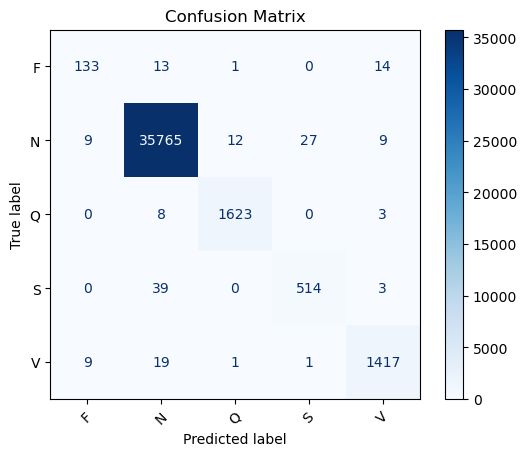

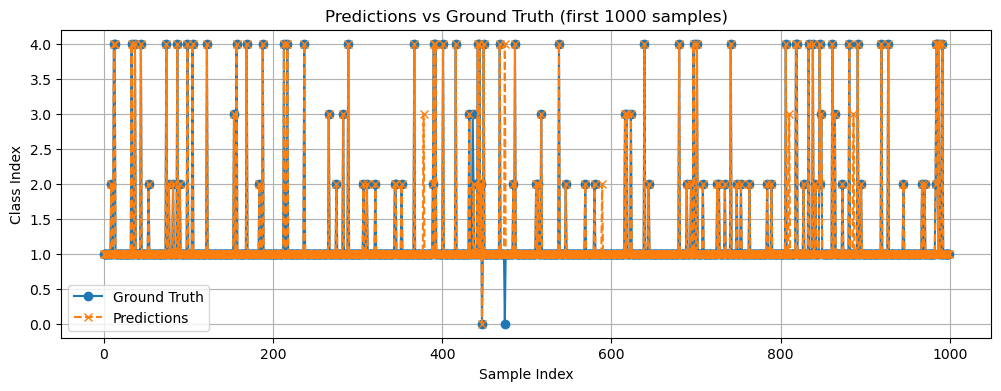

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# print("Class distribution:", Counter(y))
# class_totals = Counter(y)
# print(label_map)

#https://pmc.ncbi.nlm.nih.gov/articles/PMC4897569/#:~:text=The%20AAMI%20convention%20is%20used,ventricular%20contraction%20(PVC)%20and%20ventricular
def label_to_name(label):
    if label == 'N':
        return 'Normal beat'
    elif label == 'S':
        return 'Supraventricular ectopic beat'
    elif label == 'V':
        return 'Ventricular ectopic beat'
    elif label == 'F':
        return 'Fusion beat'
    elif label == 'Q':
        return 'Unknown beat'

def evaluate_model(model, test_loader, label_map, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Overall accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {acc * 100:.2f}%")

    # Per-class accuracy
    cm = confusion_matrix(all_labels, all_preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    index_to_label = {v: k for k, v in label_map.items()}
    for i, acc in enumerate(per_class_acc):
        label_name = index_to_label.get(i, str(i))
        print(f"{label_name}, {label_to_name(label_name)}: {acc * 100:.3f}%")

    # Confusion Matrix Plot
    display_labels = [index_to_label.get(i, str(i)) for i in range(cm.shape[0])]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # # Predictions vs. Ground Truth Plot
    # plt.figure(figsize=(12, 4))
    # plt.plot(all_labels[:1000], label='Ground Truth', marker='o', linestyle='-')
    # plt.plot(all_preds[:1000], label='Predictions', marker='x', linestyle='--')
    # plt.legend()
    # plt.title("Predictions vs Ground Truth (first 1000 samples)")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Class Index")
    # plt.grid(True)
    # plt.show()

    # Confusion Matrix Plot (normalized)
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    display_labels = [index_to_label.get(i, str(i)) for i in range(cm.shape[0])]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Normalized Confusion Matrix (per true class)")
    plt.show()

    return acc, all_preds, all_labels


acc, preds, labels = evaluate_model(model, test_loader, label_map, device)